In [1]:
import sys
import copy
import time

import numpy as np
import torch
import matplotlib.pyplot as plt
from pygsp.graphs import Graph

sys.path.insert(0, '..')
from graph_deep_decoder import datasets as ds
from graph_deep_decoder import utils

# %matplotlib qt

PATH = '../results/theorems/'
SEED = 0
SAVE = False
np.random.seed(SEED)

## Characterize graph models

In [2]:
def characterize_graph(G):
    N = G.N
    A = np.asarray(G.W.todense())
    min_degree =  np.min(np.sum(A, 1))
    D_root_inv = np.diag(1/np.sqrt(np.sum(A, 1)))
    A = D_root_inv.dot(A.dot(D_root_inv))
    L_A, V_A = utils.ordered_eig(A)
    
    # Print summary
    max_links = N*(N-1)/2
    print('N:', N, ':')
    print('\t- norm A:', np.linalg.norm(A))
    print('\t- Proportion of links:', G.Ne/max_links)
    print('\t- Min degree:', min_degree)
    print('\t- First eigenvalues:', L_A[:15])
    
    plt.figure()
    plt.imshow(A)
    plt.title('N: ' + str(N) + ' A norm')
    plt.figure()
    plt.stem(L_A, use_line_collection=True)
    plt.title('Eigenvalues of A')
    
def plot_expexted_A(Gs, n_samples):
    E_A = np.zeros((Gs['N'], Gs['N']))
    for i in range(n_samples):
        E_A += ds.create_graph(Gs, SEED).W.todense()
    E_A /= n_samples
    plt.figure()
    plt.imshow(E_A)
    plt.title('Expected A')

N: 62 :
	- norm A: 3.5571955023716173
	- Proportion of links: 0.08143839238498149
	- Min degree: 0.10398876440522013
	- First eigenvalues: [ 1.          0.99618442  0.98578462  0.96330467  0.95681823  0.88138951
  0.8643707   0.79771672  0.77993504  0.746678   -0.56036765 -0.54021315
  0.52615467 -0.49036762 -0.47436532]
N: 130 :
	- norm A: 3.736049567478036
	- Proportion of links: 0.07310673822301729
	- Min degree: 0.08630889703390099
	- First eigenvalues: [1.         0.99012378 0.97256986 0.94659827 0.94060809 0.91273394
 0.84592186 0.83833532 0.83215359 0.77875934 0.70098975 0.67684373
 0.57528549 0.47824176 0.45798646]
N: 188 :
	- norm A: 3.617515913637773
	- Proportion of links: 0.07788144271248151
	- Min degree: 0.09916962751414234
	- First eigenvalues: [1.         0.9912692  0.9698749  0.9258781  0.90098587 0.88648315
 0.83387668 0.75453067 0.73888266 0.73334372 0.67180309 0.63386631
 0.57290688 0.56882989 0.50725704]
N: 253 :
	- norm A: 3.7915189584462845
	- Proportion of links

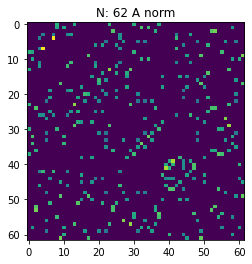

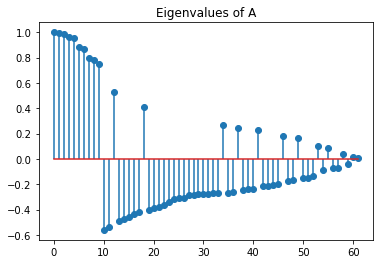

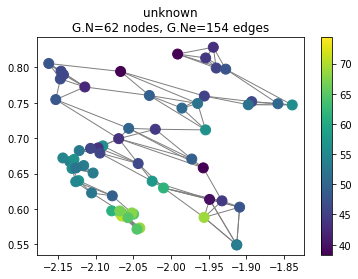

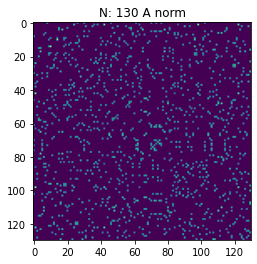

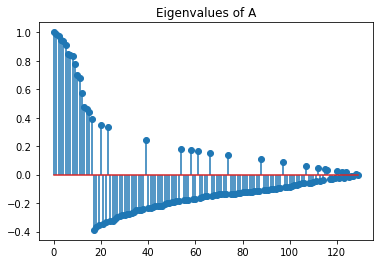

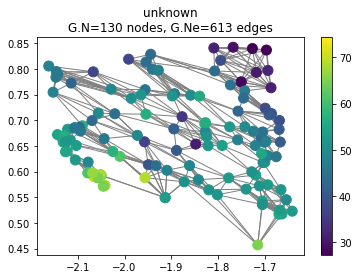

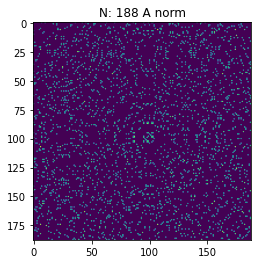

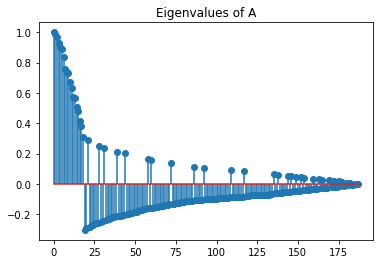

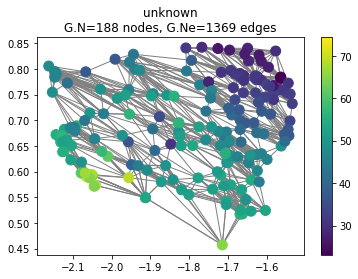

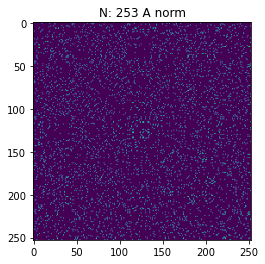

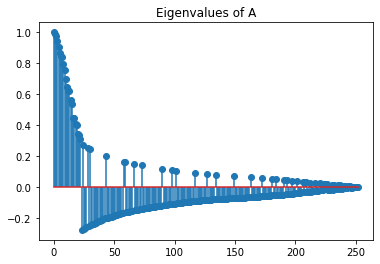

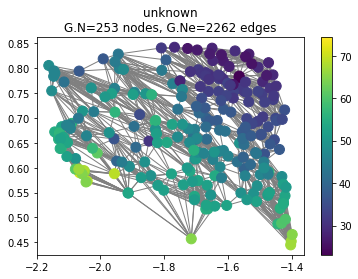

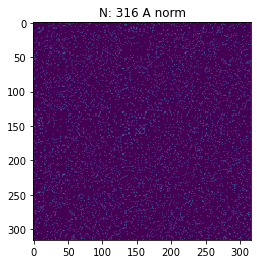

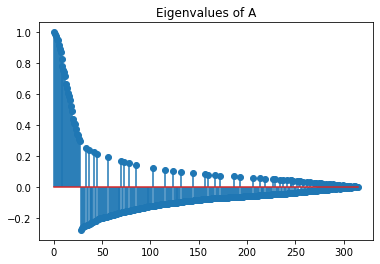

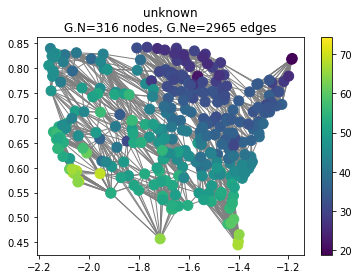

In [15]:
DATASET_PATHS = ['../dataset/temperatures2003_knn4_N62.npz',
                 '../dataset/temperatures2003_knn8_N130.npz',
                 '../dataset/temperatures2003_knn12_N188.npz',
                 '../dataset/temperatures2003_knn15_N253.npz',
                 '../dataset/temperatures2003_knn16_N316.npz']

start_time = time.time()
for path in DATASET_PATHS:
    # Read graph
    npzfile = np.load(path)
    A = npzfile['A']
    A_bin = npzfile['A_bin']
    X = npzfile['X']
    Coords = npzfile['Coords']
    G = Graph(A)
    G.set_coordinates(Coords)
    characterize_graph(G)
    G.plot_signal(X[:, 31])

print('\n--- {} minutes ---'.format((time.time()-start_time)/60))



## Check eigenvector similarity

In [16]:
np.random.seed(SEED)
DATASET_PATHS = [# Constant regular graphs with knn8
                 ['../dataset/temperatures2003_N62.npz',
                  '../dataset/temperatures2003_N130.npz',
                  '../dataset/temperatures2003_N188.npz',
                  '../dataset/temperatures2003_N253.npz',
                  '../dataset/temperatures2003_knn8_N316.npz'],
                 # Constant regular graphs with knn16
                 ['../dataset/temperatures2003_knn16_N62.npz',
                  '../dataset/temperatures2003_knn16_N130.npz',
                  '../dataset/temperatures2003_knn16_N188.npz',
                  '../dataset/temperatures2003_knn16_N253.npz',
                  '../dataset/temperatures2003_knn16_N316.npz'],
    
                  # Increasing regular graphs with knn8
                 ['../dataset/temperatures2003_knn1_N62.npz',
                  '../dataset/temperatures2003_knn3_N130.npz',
                  '../dataset/temperatures2003_knn4_N188.npz',
                  '../dataset/temperatures2003_knn6_N253.npz',
                  '../dataset/temperatures2003_knn8_N316.npz'],
                  # Increasing regular graphs with knn16
                 ['../dataset/temperatures2003_knn3_N62.npz',
                  '../dataset/temperatures2003_knn6_N130.npz',
                  '../dataset/temperatures2003_knn8_N188.npz',
                  '../dataset/temperatures2003_knn12_N253.npz',
                  '../dataset/temperatures2003_knn16_N316.npz'],
                 ]

# Filter parameters
L = 3
hs = np.random.rand(L)
hs /= np.sum(hs)
h_params = {'type': 'FixedH', 'S': 'A', 'hs': hs, 'H_norm': False}

KK = [1, 20, 25, 40]

In [17]:
err_eigvec_temp = np.zeros((len(KK), len(DATASET_PATHS[0]), len(DATASET_PATHS)))
eig_ratio_Ep_temp = np.zeros((len(KK), len(DATASET_PATHS[0]), len(DATASET_PATHS)))

eig_ratio_A_temp = np.zeros((len(DATASET_PATHS[0]), len(DATASET_PATHS)))
eig_ratio_E_temp = np.zeros((len(DATASET_PATHS[0]), len(DATASET_PATHS)))
start_time = time.time()
for i, paths in enumerate(DATASET_PATHS):
    NN = []
    print('Graph', str(i) + ':', end=' ')
    for j, path in enumerate(paths):
        A = np.load(path)['A']
        N = A.shape[0]
        NN.append(N)
        D_root_inv = np.diag(1/np.sqrt(np.sum(A, 1)))
        A = D_root_inv.dot(A.dot(D_root_inv))
        L_A, V_A = utils.ordered_eig(A)

        # Calculate Exp Jacobian
        H = utils.create_filter(A, h_params)
        H2 = H.dot(H.T)
        H_norm = H/np.linalg.norm(H, axis=0)
        H2_norm = H_norm.T.dot(H_norm)
        H2_norm[H2_norm>1] = 1
        Z = 1-np.arccos(H2_norm)/np.pi
        E_JJ = 0.5*Z*(H2)

        L_E_JJ, V_E_JJ = utils.ordered_eig(E_JJ)
        V_E_JJ = utils.choose_eig_sign(V_E_JJ, V_A)

        for k in range(len(KK)):
            K = KK[k]
            err_eigvec_temp[k, j, i] = np.linalg.norm(V_A[:, :K]-V_E_JJ[:, :K])/K
            eig_ratio_Ep_temp[k, j, i] = L_E_JJ[K-1]/L_E_JJ[K]

        eig_ratio_A_temp[j, i] = (L_A[0]/L_A[-1])**2
        eig_ratio_E_temp[j, i] = (L_E_JJ[0]/L_E_JJ[-1])**2
        
        print(N, end=' ')
    print()
    
print('\n--- {} minutes ---'.format((time.time()-start_time)/60))


Graph 0: 62 130 188 253 316 
Graph 1: 62 130 188 253 316 
Graph 2: 62 130 188 253 316 
Graph 3: 62 130 188 253 316 

--- 0.013447340329488118 minutes ---


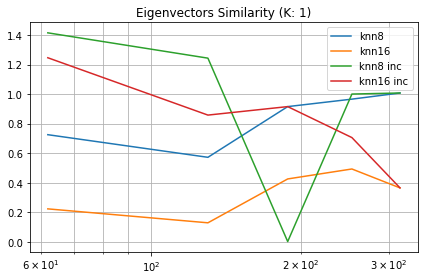

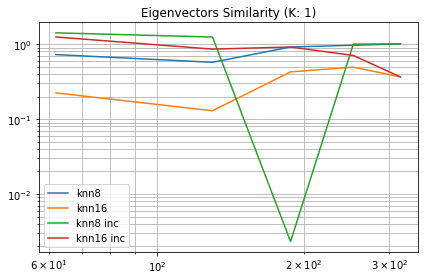

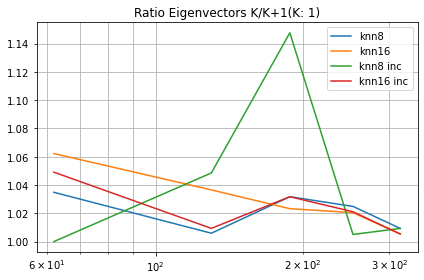

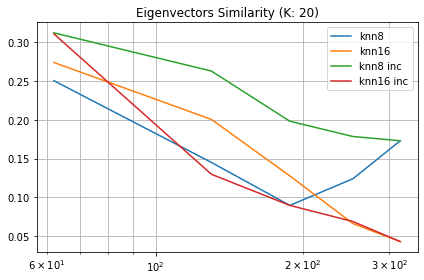

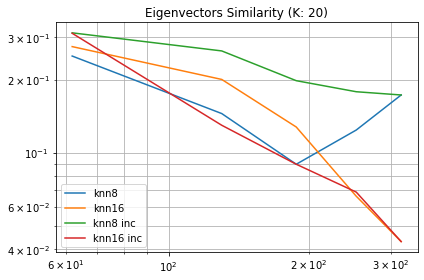

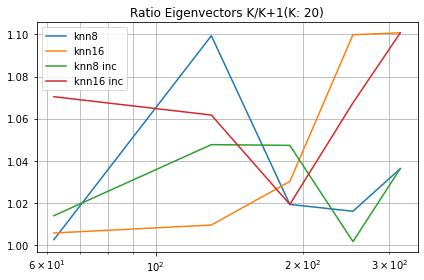

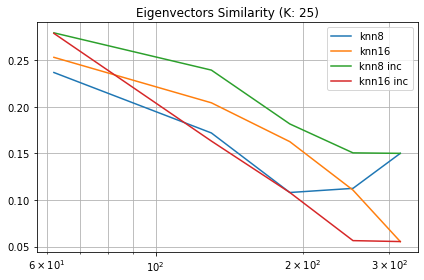

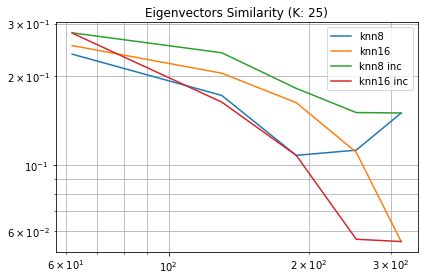

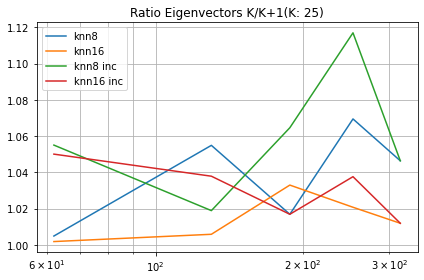

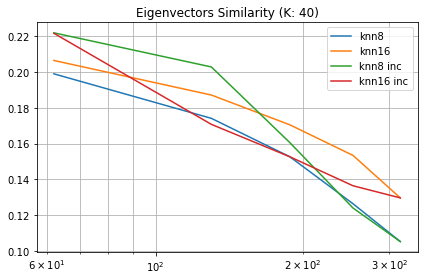

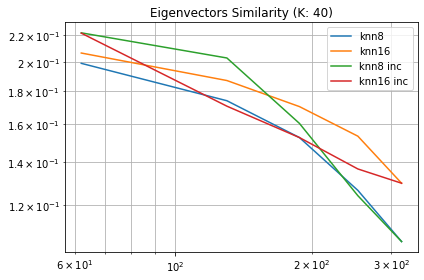

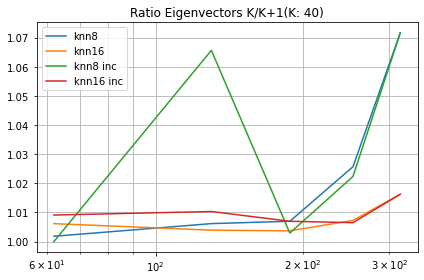

In [18]:
legend = ['knn8',
          'knn16',
          'knn8 inc',
          'knn16 inc',
         ]

for k in range(len(KK)):
    f1 = plt.figure()
    plt.semilogx(NN, err_eigvec_temp[k])
    plt.grid(True, which='both')
    plt.title('Eigenvectors Similarity (K: {})'.format(KK[k]))
    plt.legend(legend)
    plt.tight_layout()

    f3 = plt.figure()
    plt.loglog(NN, err_eigvec_temp[k])
    plt.grid(True, which='both')
    plt.title('Eigenvectors Similarity (K: {})'.format(KK[k]))
    plt.legend(legend)
    plt.tight_layout()
    
    f2 = plt.figure()
    plt.semilogx(NN, eig_ratio_Ep_temp[k])
    plt.grid(True, which='both')
    plt.title('Ratio Eigenvectors K/K+1(K: {})'.format(KK[k]))
    plt.legend(legend)
    plt.tight_layout()

    if SAVE:
        f1.savefig('{}eig_sim_tempt_k{}.png'.format(PATH, KK[k]))
        f2.savefig('{}ratio_kth_eigval_tempt_k_{}.png'.format(PATH, KK[k]))
        f3.savefig('{}ratio_kth_eigval_tempt_log_k_{}.png'.format(PATH, KK[k]))

In [20]:
plt.show()